# Future Sales Prediction: Russian Market

This notebook requires the following files, which are included in the kaggle GitHub https://github.com/data-science-if-usp/kaggle.git (but this should not be the common practice since GitHub is not for data storage)

In [1]:
# always start with checking out the files!
!ls ../input/*

../input/item_categories.csv	../input/sample_submission.csv.gz
../input/items.csv		../input/shops.csv
../input/sales_train.csv.gz	../input/test.csv
../input/sales_train_v2.csv	../input/test.csv.gz
../input/sample_submission.csv


# keras and Tensorflow are required

For the installation of these packages you can follow

http://inmachineswetrust.com/posts/deep-learning-setup/
    
which is working in ubuntu 16.04 and Anaconda (Anaconda3-2018.12-Linux-x86_64.sh)

In [2]:
import os
import math
import time
import shutil

# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
#from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

#from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
#import statsmodels.formula.api as smf
#import statsmodels.tsa.api as smt
#import statsmodels.api as sm
import scipy.stats as scs

import datetime as dt

from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt


# settings
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm_notebook, tnrange


Using TensorFlow backend.


# Import all data using pandas  


In [3]:
# Import all data inmediately  
sales=pd.read_csv("../input/sales_train_v2.csv")

# settings
import warnings
warnings.filterwarnings("ignore")

item_cat=pd.read_csv("../input/item_categories.csv")
item=pd.read_csv("../input/items.csv")
sub=pd.read_csv("../input/sample_submission.csv")
shops=pd.read_csv("../input/shops.csv")
test=pd.read_csv("../input/test.csv")

In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


# Formatting the date column propertly

In [7]:
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


# Using the item file: number of items per category

Let us start analyzing the file item.csv. In this file, we have the item_name, item_id and item_category_id columns. Basically we have several items that belong to the same category

In [8]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
x=item.groupby(['item_category_id']).count()

Therefore, x is a table that contain the number of items per each category. Also we have to notice that the counting is applied in all the columns apart from item_category_id, in our case this corresponds to the columns item_name and item_id. In each row it is going to be record the number of item_names or item_id associated with each category 

In [10]:
x.head()

,item_name,item_id
item_category_id,,
0,4,4
1,2,2
2,75,75
3,34,34
4,15,15


In [11]:
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


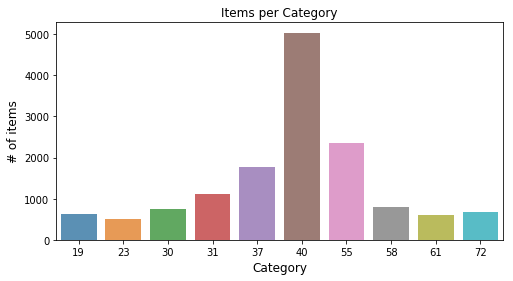

In [12]:
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

# Abouth the feature category_id and the missing files

It seems interesting to consider this feature to be included in the time series analysis because we can use it to have some idea about how to predict the missing products, that only appear in the test but not in the train. 

It is clear that even if the product does not have a time series, at least it has a category_id because in the folder item.csv appear all the products and their respective cathegories.

We are not necessarily thinking to include this feature in the training of the month prediction number of sales but in a posterior step when we use this feature together with the predictions of each product in order to compute a value of the prediction for the missing files.

Example: <br>

Table generated by the time-series predictor using simply the monthly counting for each independente pair of product-shop:

Item_id | Shop_id | Prediction

Thus, in principle we do not know the prediction for products that do not have a time-series in the train. However, we could add the cathegory_id to the table

Item_id | Shop_id | Cathegory_id | Prediction

and know we have at least the chance to consider the prediction of the missing products by considering the Cathegory_id information. You can take the average over the pairs with the same cathegory or you can choose randomly, etc. 

Of course, there is a lot more that we can explore in this dataset, but let's dive into the time-series part.

# Single series:

The objective requires us to predict sales for the next month at a store-item combination.

Sales over time of each store-item is a time-series in itself. Therefore, we can analyze the evolution of each pair independently. 

Therefore, let's understand how to forecast for a single series.

In [13]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


# Just as an example we consider the total sales per month for the entire company.


## Definition of ts = date_block,  item_cnt_day.sum dataframe

We declare a new variable to define the data to analyze in terms of time series predictions
basically, the item_cnt_day added in differents directions, such as date_block_num or date_block_num x shop_id x item_id, etc.

In [14]:
#declaration of time-series kind of variable ts with groupby, but the structure is simple

ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()

In [15]:
ts.head()

date_block_num
0    131479.0
1    128090.0
2    147142.0
3    107190.0
4    106970.0
Name: item_cnt_day, dtype: float64

In [16]:
ts.shape

(34,)

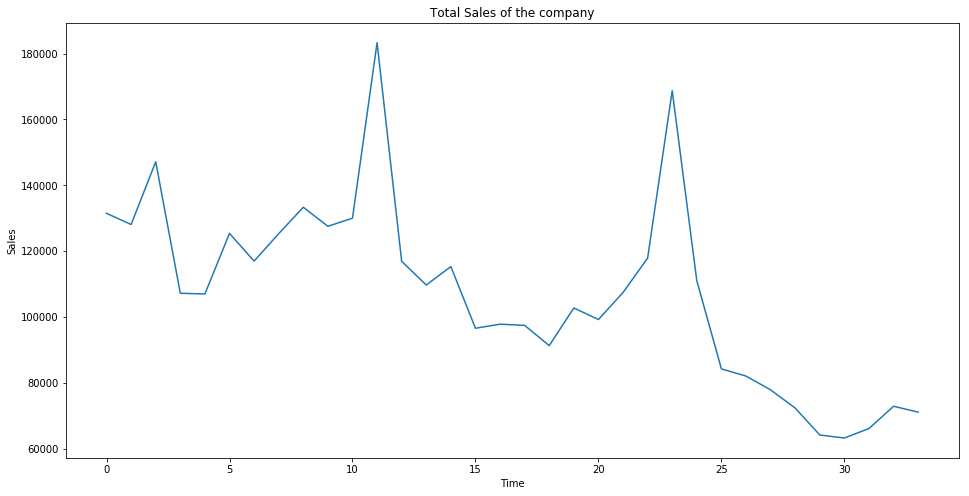

In [17]:
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

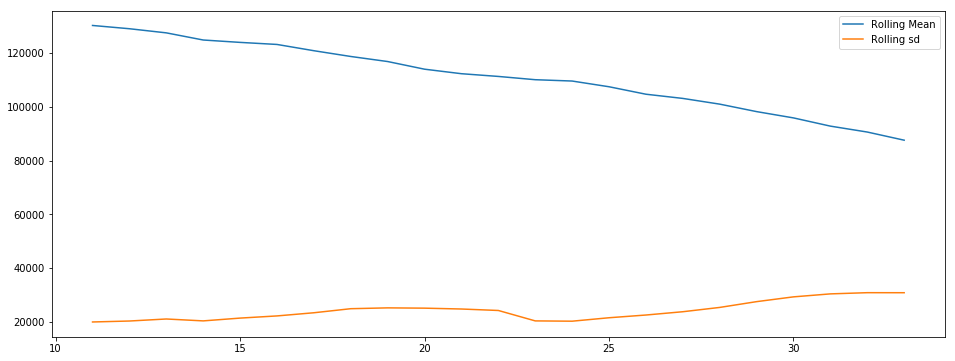

In [8]:
#with ts.rolling we are computing the mean and std of sales grouped in windows of size 12 in units of time (block times, indeed)

plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

Now we can guess that each pair store-product has a similar behavior, with more or less resolution. Therefore the idea is to extrapolate this kind of function for each pair. 

# For the extrapolation, for instance, we can use the LSTM model 

For theoretical background see http://colah.github.io/posts/2015-08-Understanding-LSTMs/ and Pablo's notes

The objective of this example is to show how to implement this model for our problem for this very simple case. This model can be compared to other approaches, but not necessarily by using theoretical arguments. Since the output of the model is exactly what is required by the challenge, we can direclty compute a chi2 metric over the subset of pairs that we are interested on. For instance we could consider all the items of the test that appear in the training, which is what we are going to try here. Afterwards we can use this infor to compare with other models, probably also well motivated theoretically but definetly with different measureble values of the metric

In [18]:
#checking the requirements of the test file

test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [19]:
item[item.item_id == 50]

,item_name,item_id,item_category_id
50,100 лучших произведений Рахманинова (mp3-CD) (...,50,57


In [20]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [21]:
len(item[item.item_category_id == 40])

5035

# Monthly sales in the (shop_id, item_category_id) space

For each pair of store_id and prod_cat_id(item_id) we compute the average sales per day (from different products that can be saled the same day) and afterwards we compute the montly sales by adding all these contributions. 

First, we test the idea and later we build the routine that create the corresponding time-series for a given (shop_id,item_category_id(item_id)) pair, which we use to compute the prediction for (shop_id, item_id) from the test

In [22]:
prod_cat = item[item.item_id == 5037]['item_category_id'].get_values()[0]
prod_cat

19

In [23]:
len(item[item.item_category_id == prod_cat])

628

Above we compute the number of items associated to a given item_category_id, but not every item is saled each day. Therefore when we average over different products we need to consider only the saled products.

### Firts of all, let us add item_category_id to the sales

In [24]:
sales_join_cat = sales.join(item, on='item_id', rsuffix='_').join(item_cat, on='item_category_id', rsuffix='_').drop(['item_id_', 'item_category_id_'], axis=1)
sales_join_cat.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


### Now, we select only on pair (shop_id,prod_cat) 

In [25]:
sales_join_prod_store = sales_join_cat[(sales_join_cat.item_category_id == prod_cat) & (sales_join_cat.shop_id == 25)]
sales_join_prod_store

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
33,2013-01-02,0,25,2715,899.0,1.0,"Darksiders (Essentials) [PS3, русская документ...",19,Игры - PS3
34,2013-01-12,0,25,2715,898.5,1.0,"Darksiders (Essentials) [PS3, русская документ...",19,Игры - PS3
37,2013-01-02,0,25,2719,2699.0,1.0,"Darksiders II [PS3, русская версия]",19,Игры - PS3
38,2013-01-12,0,25,2719,2699.0,1.0,"Darksiders II [PS3, русская версия]",19,Игры - PS3
39,2013-01-25,0,25,2719,1699.0,1.0,"Darksiders II [PS3, русская версия]",19,Игры - PS3
52,2013-01-04,0,25,2748,1399.0,1.0,"Dead Space 2 [PS3, русская версия]",19,Игры - PS3
53,2013-01-23,0,25,2748,799.0,1.0,"Dead Space 2 [PS3, русская версия]",19,Игры - PS3
54,2013-01-25,0,25,2748,799.0,1.0,"Dead Space 2 [PS3, русская версия]",19,Игры - PS3
65,2013-01-14,0,25,2835,1999.0,1.0,"Dishonored [PS3, русские субтитры]",19,Игры - PS3
66,2013-01-19,0,25,2835,1999.0,1.0,"Dishonored [PS3, русские субтитры]",19,Игры - PS3


In [27]:
item_sales = sales_join_prod_store.groupby(['item_id'], as_index=False).agg({'item_cnt_day':'sum'})
item_sales

,item_id,item_cnt_day
0,27,3.0
1,948,20.0
2,950,25.0
3,1359,1.0
4,1372,1.0
5,1388,30.0
6,1397,1.0
7,1403,7.0
8,1407,58.0
9,1409,7.0


In [28]:
len(item_sales[item_sales.item_id == 999])

0

In [29]:
item_unique_sales = item_sales[item_sales.item_id == 27]['item_cnt_day'].get_values()[0]
item_unique_sales

3.0

In [30]:
total_item_sales = item_sales['item_cnt_day'].sum()
total_item_sales

13596.0

### For each day we average the item_cnt_day

We keep the date_block_num in order to sum all the sales later

In [31]:
ndf = sales_join_prod_store.groupby(['date','date_block_num'], as_index=False).agg({'item_cnt_day': 'mean'})
ndf

,date,date_block_num,item_cnt_day
0,2013-01-02,0,1.166667
1,2013-01-03,0,1.285714
2,2013-01-04,0,1.200000
3,2013-01-05,0,1.095238
4,2013-01-06,0,1.222222
5,2013-01-07,0,1.062500
6,2013-01-08,0,1.153846
7,2013-01-09,0,1.181818
8,2013-01-10,0,1.125000
9,2013-01-11,0,1.066667


In [32]:
ndf.groupby(['date_block_num'])['item_cnt_day'].sum()

date_block_num
0     35.877462
1     35.772211
2     44.120351
3     37.227185
4     34.886622
5     44.135054
6     41.593398
7     39.534738
8     82.793033
9     67.037632
10    38.895199
11    40.552755
12    34.336397
13    34.823095
14    38.904148
15    32.105159
16    39.328577
17    35.237331
18    33.262247
19    35.464472
20    37.163689
21    35.798962
22    45.494048
23    35.373383
24    30.562594
25    29.729365
26    31.828247
27    31.715873
28    36.559524
29    30.428571
30    32.544444
31    30.680952
32    50.098485
33    34.400000
Name: item_cnt_day, dtype: float64

# Routines

In [40]:
def sales_time_series_shopId_catId(store_id, prod_id):
    
    #product category associated to the prod_id
    prod_cat = item[item.item_id == prod_id]['item_category_id'].get_values()[0]
    
    #extended sales df, including item_category_id
    sales_join_cat = sales.join(item, on='item_id', rsuffix='_').join(item_cat, on='item_category_id', rsuffix='_').drop(['item_id_', 'item_category_id_'], axis=1)
    
    #reduced df filtering by product_category and shop_id. Still, we have several products involved for each day
    sales_prod_store = sales_join_cat[(sales_join_cat.item_category_id == prod_cat) & (sales_join_cat.shop_id == store_id)]
    
    #for the sale of each day we consider the mean over different products
    #we use agrr instead of mean() because it generates a dataframe wchich is very readable
    sales_prod_store_av_day = sales_prod_store.groupby(['date','date_block_num'], as_index=False).agg({'item_cnt_day': 'mean'})
    
    #for monthly summary sales we consider the total sum of days
    monthly_sales = sales_prod_store_av_day.groupby(["date_block_num"])["item_cnt_day"].sum()
    
    #we normalize the montly sale of the given product by the probability to sale that product in the shop 
    #we compute that probability as given by the total_sales_product/total_sales_category
    
    prob_product = 0  
        
    #total sales of each item for this particular shop 
    item_sales_all = sales_prod_store.groupby(['item_id'], as_index=False).agg({'item_cnt_day':'sum'})
    
    #first, we check if this item has been sold at all
    if len(item_sales_all[item_sales_all.item_id == prod_id] > 0):
        total_item_sales = item_sales_all['item_cnt_day'].sum()
        indiv_item_sales = item_sales_all[item_sales_all.item_id == prod_id]['item_cnt_day'].get_values()[0]
        
        prob_product = indiv_item_sales/total_item_sales
        
    #monthly_sales = monthly_sales*prob_product
    
    #reset of months lables
    dates = pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
    
    nullhistory = pd.DataFrame({"node_tot_cnt":[0]*dates.shape[0]},columns=["node_tot_cnt"])
    
    if (sales_prod_store.shape[0] > 0):
        for con in range(monthly_sales.shape[0]): 
            index_date_block = monthly_sales.index[con]
            count_date_block = monthly_sales.iloc[con]
   
            # here we fill the histories, always leaving the zero position to the featiure 
            # to be predicted [0]!!!!
            nullhistory.iloc[index_date_block,0] = count_date_block
     
    return prob_product, nullhistory

def sales_summary_dataframe(shop_id_history, item_id_history):
   
    sales_shop_item = sales[(sales.shop_id==shop_id_history) & (sales.item_id == item_id_history)]
    
    monthly_sales_shop_item = sales_shop_item.groupby(["date_block_num"])["item_cnt_day"].sum()
    
    dates = pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
    
    nullhistory = pd.DataFrame({"node_tot_cnt":[0]*dates.shape[0]},columns=["node_tot_cnt"])
    
    if (sales_shop_item.shape[0] > 0):
        for con in range(monthly_sales_shop_item.shape[0]): 
            index_date_block = monthly_sales_shop_item.index[con]
            count_date_block = monthly_sales_shop_item.iloc[con]
   
            # here we fill the histories, always leaving the zero position to the featiure 
            # to be predicted [0]!!!!
            nullhistory.iloc[index_date_block,0] = count_date_block
    
    return nullhistory    

In [34]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    # Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [35]:
class Timer():

    def __init__(self):
        self.start_dt = None

    def start(self):
        self.start_dt = dt.datetime.now()

    def stop(self):
        end_dt = dt.datetime.now()
        print('Time taken: %s' % (end_dt - self.start_dt))

In [36]:
class Model():
    """A class for an building and inferencing an lstm model"""

    def __init__(self):
        self.model = Sequential()

    def load_model(self, filepath):
        print('[Model] Loading model from file %s' % filepath)
        self.model = load_model(filepath)

    def build_model(self, configs):
        timer = Timer()
        timer.start()

        for layer in configs['model']['layers']:
            neurons = layer['neurons'] if 'neurons' in layer else None
            dropout_rate = layer['rate'] if 'rate' in layer else None
            activation = layer['activation'] if 'activation' in layer else None
            return_seq = layer['return_seq'] if 'return_seq' in layer else None
            input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
            input_dim = layer['input_dim'] if 'input_dim' in layer else None

            if layer['type'] == 'dense':
                self.model.add(Dense(neurons, activation=activation))
            if layer['type'] == 'lstm':
                self.model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
            if layer['type'] == 'dropout':
                self.model.add(Dropout(dropout_rate))

        self.model.compile(loss=configs['model']['loss'], optimizer=configs['model']['optimizer'])

        print('[Model] Model Compiled')
        timer.stop()

    def train(self, x, y, epochs, batch_size, save_dir):
        timer = Timer()
        timer.start()
        print('[Model] Training Started')
        print('[Model] %s epochs, %s batch size' % (epochs, batch_size))

        save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
        ]
        
        self.model.fit(x, y, epochs=epochs, batch_size=batch_size, callbacks=callbacks)
        self.model.save(save_fname)

        print('[Model] Training Completed. Model saved as %s' % save_fname)
        timer.stop()

    def train_generator(self, data_gen, epochs, batch_size, steps_per_epoch, save_dir):
        timer = Timer()
        timer.start()
        print('[Model] Training Started')
        print('[Model] %s epochs, %s batch size, %s batches per epoch' % (epochs, batch_size, steps_per_epoch))
        
        save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
        callbacks = [
            ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
        ]
        self.model.fit_generator(
            data_gen,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            callbacks=callbacks,
            workers=1
        )

        print('[Model] Training Completed. Model saved as %s' % save_fname)
        timer.stop()

    def predict_point_by_point(self, data):
        #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
        print('[Model] Predicting Point-by-Point...')
        predicted = self.model.predict(data)
        predicted = np.reshape(predicted, (predicted.size,))
        return predicted

    def predict_sequences_multiple(self, data, window_size, prediction_len):
        #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
        print('[Model] Predicting Sequences Multiple...')
        prediction_seqs = []
        for i in range(int(len(data)/prediction_len)):
            curr_frame = data[i*prediction_len]
            predicted = []
            for j in range(prediction_len):
                predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
                curr_frame = curr_frame[1:]
                curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
            prediction_seqs.append(predicted)
        return prediction_seqs

    def predict_sequence_full(self, data, window_size):
        #Shift the window by 1 new prediction each time, re-run predictions on new window
        print('[Model] Predicting Sequences Full...')
        curr_frame = data[0]
        predicted = []
        for i in range(len(data)):
            predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
        return predicted

In [37]:
class DataLoader():
    """A class for loading and transforming data for the lstm model"""

    def __init__(self, dataframe, split, cols):
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe.get(cols).values[:i_split]
        self.data_test  = dataframe.get(cols).values[i_split:]
        self.len_train  = len(self.data_train)
        self.len_test   = len(self.data_test)
        self.len_train_windows = None

    def get_test_data(self, seq_len, normalise):
        '''
        Create x, y test data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise reduce size of the training split.
        '''
        data_windows = []
        for i in range(self.len_test - seq_len):
            data_windows.append(self.data_test[i:i+seq_len])

        data_windows = np.array(data_windows).astype(float)
        data_windows = self.normalise_windows(data_windows, single_window=False) if normalise else data_windows

        x = data_windows[:, :-1]
        y = data_windows[:, -1, [0]]
        return x,y

    def get_train_data(self, seq_len, normalise):
        '''
        Create x, y train data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise use generate_training_window() method.
        '''
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def generate_train_batch(self, seq_len, batch_size, normalise):
        '''Yield a generator of training data from filename on given list of cols split for train/test'''
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    # stop-condition for a smaller final batch if data doesn't divide evenly
                    yield np.array(x_batch), np.array(y_batch)
                    i = 0
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1
            yield np.array(x_batch), np.array(y_batch)

    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i'''
        window = self.data_train[i:i+seq_len]
        window = self.normalise_windows(window, single_window=True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                
                
                #normalised_col = [((float(p) / window[0,col_i]) - 1) for p in window[:, col_i]]
                
                #new normalization necessary since there are several times when window[0,col_i]=0
                #but still we like the idea to normalize each window wrt to the initial value
                
                normalised_col = [(float(p) - window[0,col_i]) for p in window[:, col_i]]
                
                normalised_window.append(normalised_col)
                
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
            normalised_data.append(normalised_window)
        return np.array(normalised_data)

In [38]:
#we are going to use all the input file as train train_test_split": 1.0
#since we just need to predict the next month sales

#input_timesteps MUST BE EQUAL to sequence_length - 1
#in order to avoid array size compatibility problems

sequence_length = 6
input_timesteps = sequence_length - 1

configs = {"data": {"filename": "sales_train_v2.csv", "columns": ["node_tot_cnt"],
                    "sequence_length": sequence_length, "train_test_split": 1.0, "normalise": True},
           "training": {"epochs": 2, "batch_size": 8},
           "model": {"loss": "mse", "optimizer": "adam", "save_dir": "saved_models",
                     "layers": [{"type": "lstm", "neurons": 100, "input_timesteps": input_timesteps, 
                                 "input_dim": 1, "return_seq": True},
                                {"type": "dropout", "rate": 0.2},
                                {"type": "lstm", "neurons": 100, "return_seq": True},
                                {"type": "lstm", "neurons": 100, "return_seq": False},
                                {"type": "dropout", "rate": 0.2},
                                {"type": "dense", "neurons": 1, "activation": "linear"}]}}

In [ ]:
start_time=time.time()

if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

model = Model()
model.build_model(configs)
 
list_of_nodes =[]
list_of_predictions = []

status_file = open('status_file_LSTM.txt','w+')
status_file.write("Dont be patient\n")
status_file.close()

#for node in range(len(test)):
    
for node in tqdm_notebook(range(len(test))):
#for node in tqdm_notebook(range(40)):    
    
    
    #restarting the save_dir file because we are assuming that each node is an
    #independent set of data
    
    shutil.rmtree(configs['model']['save_dir'], ignore_errors=True)
    os.makedirs(configs['model']['save_dir'])
    
    # reading the node address
    # as cab seen above, the position 1 of the test file has the shop and the 2 the item id

    test_shop_id_index = test.iloc[node,1]
    test_item_id_index = test.iloc[node,2]
    
    #creating the summary data frame
    #see the function declared above for more details. This is quite important because is the
    #input for the time-series prediction 
    
    #sales_summary_df = sales_summary_dataframe(test_shop_id_index, test_item_id_index)
    
    #sales_summary_df = sales_summary_dataframe(test_shop_id_index, test_item_id_index)
    prob_product, sales_summary_df = sales_time_series_shopId_catId(test_shop_id_index, test_item_id_index)   

    #print(sales_summary_df)
    #using summary data frame to define the LSTM input as in Stock Market Predictor

    data = DataLoader(sales_summary_df,
                  configs['data']['train_test_split'],
                  configs['data']['columns'])

    steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
    
    model.train_generator(
                data_gen=data.generate_train_batch(
                seq_len=configs['data']['sequence_length'],
                batch_size=configs['training']['batch_size'],
                normalise=configs['data']['normalise']
                ),
                epochs=configs['training']['epochs'],
                batch_size=configs['training']['batch_size'],
                steps_per_epoch=steps_per_epoch,
                save_dir=configs['model']['save_dir']
        )

     #making prediction based in the last block of months (for now we are using 5 months)
     #this is clearly more consistent when we use normalize = False in configs variable
     #when we use normalize = True we should be carefull about final predictions, because
     #they could be afected by the normalization of the training data 
        
    ini_element = sales_summary_df.values.shape[0]-configs['data']['sequence_length'] + 1
    end_element = sales_summary_df.values.shape[0]
    last_train_block = np.array([sales_summary_df.values[ini_element:end_element]])

    #prediction for next month based on precious sequence_length months (last train block!!)
    memory_based_prediction_for_next_month = model.predict_point_by_point(last_train_block)
    
    list_of_nodes.append(node)
    
    lstm_prediction = memory_based_prediction_for_next_month[0]*prob_product

    if (lstm_prediction > 20):
        lstm_prediction = 20
        
    if (lstm_prediction < 0):
        lstm_prediction = 0
        
       
    list_of_predictions.append(lstm_prediction)
    
    if (((node % 10 == 0) and (node < 100)) or (node % 1000 == 0)):
        end_time=time.time()
        
        #status_output = "forecasting for "+ str(node) +"th node and took" + str(end_time-start_time) + "s"

        status_file = open('status_file_LSTM.txt','a')
        
        status_file.write("Node "+ str(node) +" took " + str(end_time-start_time) + " s with ") 
        status_file.write("LSTM Prediction (saved) and prob_prod: "+ str(memory_based_prediction_for_next_month[0]) + " ("+ str(lstm_prediction) +") " + str(prob_product) + "\n")

        status_file.close()

        #print()
        start_time=end_time

#total submission file        
        
    
    
dfsubmission = pd.DataFrame({"ID":list_of_nodes,"item_cnt_month":list_of_predictions},
                            columns=["ID","item_cnt_month"])

dfsubmission.to_csv('submission_file_LSTM_normalized_True_ShopId_CategoryId_Pred.csv',index=False)

[Model] Model Compiled
Time taken: 0:00:00.500927


[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 2s 410ms/step - loss: 91.4807
Epoch 2/2
4/4 [==============================] - 0s 8ms/step - loss: 86.7990
[Model] Training Completed. Model saved as saved_models/19032019-204557-e2.h5
Time taken: 0:00:03.783055
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 15ms/step - loss: 36.9507
Epoch 2/2
4/4 [==============================] - 0s 15ms/step - loss: 33.3856
[Model] Training Completed. Model saved as saved_models/19032019-204602-e2.h5
Time taken: 0:00:00.183094
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 13ms/step - loss: 73.5698
Epoch 2/2
4/4 [==============================] - 0s 13ms/step - loss: 67.2733
[Model] Training 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 13ms/step - loss: 23.5314
Epoch 2/2
4/4 [==============================] - 0s 14ms/step - loss: 22.1523
[Model] Training Completed. Model saved as saved_models/19032019-204626-e2.h5
Time taken: 0:00:00.163134
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 13ms/step - loss: 37.7256
Epoch 2/2
4/4 [==============================] - 0s 14ms/step - loss: 34.1867
[Model] Training Completed. Model saved as saved_models/19032019-204627-e2.h5
Time taken: 0:00:00.166751
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 13ms/step - loss: 41.6028
Epoch 2/2
4/4 [==============================] - 0s 14ms/step - loss: 39.5853
[Model] Training 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 13ms/step - loss: 21.8558
Epoch 2/2
4/4 [==============================] - 0s 12ms/step - loss: 20.5874
[Model] Training Completed. Model saved as saved_models/19032019-204652-e2.h5
Time taken: 0:00:00.160838
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 12ms/step - loss: 21.3310
Epoch 2/2
4/4 [==============================] - 0s 12ms/step - loss: 20.2174
[Model] Training Completed. Model saved as saved_models/19032019-204653-e2.h5
Time taken: 0:00:00.151212
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 12ms/step - loss: 19.7548
Epoch 2/2
4/4 [==============================] - 0s 13ms/step - loss: 19.9339
[Model] Training 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 13ms/step - loss: 18.5586
Epoch 2/2
4/4 [==============================] - 0s 14ms/step - loss: 16.2841
[Model] Training Completed. Model saved as saved_models/19032019-204718-e2.h5
Time taken: 0:00:00.167639
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 14ms/step - loss: 17.1672
Epoch 2/2
4/4 [==============================] - 0s 12ms/step - loss: 17.6178
[Model] Training Completed. Model saved as saved_models/19032019-204719-e2.h5
Time taken: 0:00:00.184782
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 14ms/step - loss: 5.4196
Epoch 2/2
4/4 [==============================] - 0s 12ms/step - loss: 4.9454
[Model] Training Co

[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 13ms/step - loss: 27.6693
Epoch 2/2
4/4 [==============================] - 0s 12ms/step - loss: 26.8284
[Model] Training Completed. Model saved as saved_models/19032019-204743-e2.h5
Time taken: 0:00:00.156236
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 14ms/step - loss: 27.8551
Epoch 2/2
4/4 [==============================] - 0s 13ms/step - loss: 23.5509
[Model] Training Completed. Model saved as saved_models/19032019-204744-e2.h5
Time taken: 0:00:00.161612
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 15ms/step - loss: 14.4043
Epoch 2/2
4/4 [==============================] - 0s 12ms/step - loss: 14.6714
[Model] Training 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 14ms/step - loss: 45.4237
Epoch 2/2
4/4 [==============================] - 0s 14ms/step - loss: 42.8484
[Model] Training Completed. Model saved as saved_models/19032019-204809-e2.h5
Time taken: 0:00:00.169022
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 17ms/step - loss: 13.7504
Epoch 2/2
4/4 [==============================] - 0s 14ms/step - loss: 13.1848
[Model] Training Completed. Model saved as saved_models/19032019-204810-e2.h5
Time taken: 0:00:00.177910
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 12ms/step - loss: 32.5259
Epoch 2/2
4/4 [==============================] - 0s 12ms/step - loss: 29.0106
[Model] Training 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 13ms/step - loss: 55.0996
Epoch 2/2
4/4 [==============================] - 0s 14ms/step - loss: 46.6401
[Model] Training Completed. Model saved as saved_models/19032019-204835-e2.h5
Time taken: 0:00:00.161402
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 12ms/step - loss: 39.1829
Epoch 2/2
4/4 [==============================] - 0s 13ms/step - loss: 34.7487
[Model] Training Completed. Model saved as saved_models/19032019-204836-e2.h5
Time taken: 0:00:00.162569
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 13ms/step - loss: 26.4614
Epoch 2/2
4/4 [==============================] - 0s 17ms/step - loss: 22.4569
[Model] Training 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 12ms/step - loss: 9.5554
Epoch 2/2
4/4 [==============================] - 0s 12ms/step - loss: 9.6430
[Model] Training Completed. Model saved as saved_models/19032019-204901-e2.h5
Time taken: 0:00:00.129122
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 16ms/step - loss: 7.6543
Epoch 2/2
4/4 [==============================] - 0s 15ms/step - loss: 7.9744
[Model] Training Completed. Model saved as saved_models/19032019-204902-e2.h5
Time taken: 0:00:00.161175
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 13ms/step - loss: 9.9133
Epoch 2/2
4/4 [==============================] - 0s 12ms/step - loss: 10.2328
[Model] Training Compl

[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 13ms/step - loss: 38.2962
Epoch 2/2
4/4 [==============================] - 0s 13ms/step - loss: 30.8409
[Model] Training Completed. Model saved as saved_models/19032019-204927-e2.h5
Time taken: 0:00:00.159364
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 13ms/step - loss: 4.2834
Epoch 2/2
4/4 [==============================] - 0s 11ms/step - loss: 4.4079
[Model] Training Completed. Model saved as saved_models/19032019-204928-e2.h5
Time taken: 0:00:00.162623
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 12ms/step - loss: 6.2416
Epoch 2/2
4/4 [==============================] - 0s 13ms/step - loss: 6.6184
[Model] Training Comp

[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 12ms/step - loss: 21.8038
Epoch 2/2
4/4 [==============================] - 0s 13ms/step - loss: 19.6659
[Model] Training Completed. Model saved as saved_models/19032019-204952-e2.h5
Time taken: 0:00:00.160691
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 15ms/step - loss: 40.2039
Epoch 2/2
4/4 [==============================] - 0s 12ms/step - loss: 36.5211
[Model] Training Completed. Model saved as saved_models/19032019-204954-e2.h5
Time taken: 0:00:00.168973
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 16ms/step - loss: 0.6913
Epoch 2/2
4/4 [==============================] - 0s 14ms/step - loss: 0.4675
[Model] Training Co

[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 13ms/step - loss: 43.0092
Epoch 2/2
4/4 [==============================] - 0s 12ms/step - loss: 34.2173
[Model] Training Completed. Model saved as saved_models/19032019-205018-e2.h5
Time taken: 0:00:00.163731
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 19ms/step - loss: 20.4352
Epoch 2/2
4/4 [==============================] - 0s 17ms/step - loss: 20.0317
[Model] Training Completed. Model saved as saved_models/19032019-205019-e2.h5
Time taken: 0:00:00.208994
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 14ms/step - loss: 28.8628
Epoch 2/2
4/4 [==============================] - 0s 13ms/step - loss: 26.1949
[Model] Training 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 13ms/step - loss: 26.3892
Epoch 2/2
4/4 [==============================] - 0s 13ms/step - loss: 26.9076
[Model] Training Completed. Model saved as saved_models/19032019-205044-e2.h5
Time taken: 0:00:00.161810
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 12ms/step - loss: 35.3120
Epoch 2/2
4/4 [==============================] - 0s 11ms/step - loss: 31.3501
[Model] Training Completed. Model saved as saved_models/19032019-205045-e2.h5
Time taken: 0:00:00.147626
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 4 batches per epoch
Epoch 1/2
4/4 [==============================] - 0s 14ms/step - loss: 6.4160
Epoch 2/2
4/4 [==============================] - 0s 12ms/step - loss: 6.0754
[Model] Training Co